In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [2]:
import sunradiation as sun
import weatherfeed as wf

# Modèle 02

Calcul de l'équilibre thermique des tuiles du toit, prennant en compte :
    - Le rayonement solaire sur le toit
    - Le rayonement propres des tuiles (corps noir)
    - La convection avec l'air extérieur (forcée par le vent, ou bien naturelle)
    
     
schéma :   
<img src="images/sch_model02.jpg" width="450px" alt='schema mod02' />


Le flux de chaleur à travers l'isolation du toit est considérée négligeable.


* Modèle sans les flux radiatifs
* Modèle avec les flux radiatifs
* Modèle avec l'intertie thermique des tuiles

## Get the data

### Météo

In [4]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday, lastday = pd.to_datetime('20/06/2017'), pd.to_datetime('now')

In [5]:
# download the data:
data = wf.buildmultidayDF(startday, lastday, coords_grenoble )

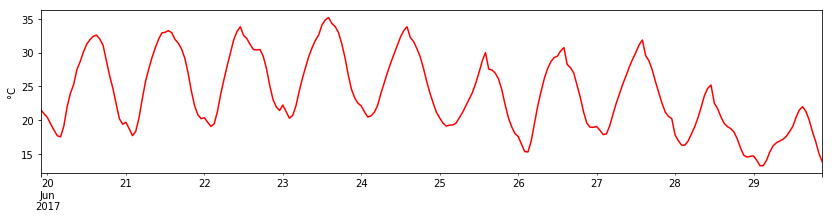

In [6]:
data['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

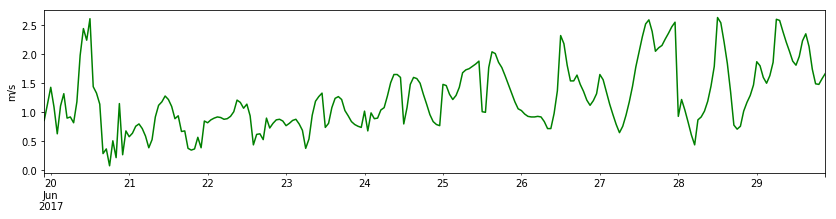

In [7]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s');

### Irradiation solaire

In [8]:
""" Get the irradiation flux data (sun position)
    and build a dataframe
"""
def buildfluxdataframe(dateindex, cloudCover, coords, sigma, phi_C):
    df = [ sun.get_flux_surface( coords, d, sigma, phi_C ) \
                 for d in dateindex ]*( 1 - cloudCover )
    
    return df

In [11]:
""" Projète le flux pour les surfaces du toit
"""

sigma = 37  # deg, angle du toit
phi_C_bastille = 50  # deg, azimuth du toit
phi_C_vercors = 50+180  # deg, azimuth du toit


data['Flux_bastille'] = buildfluxdataframe(data.index, data['cloudCover'], \
                                           coords_grenoble, sigma, phi_C_bastille)


data['Flux_vercors'] = buildfluxdataframe(data.index, data['cloudCover'], \
                                           coords_grenoble, sigma, phi_C_vercors)


/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


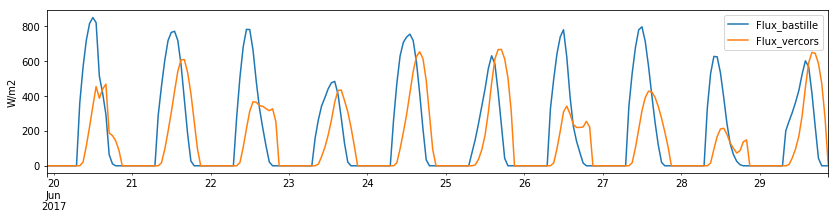

In [12]:
data[['Flux_bastille', 'Flux_vercors']].plot(figsize=(14, 3) )
plt.ylabel('W/m2');

## Grandeurs physiques

In [13]:
""" Fonction du coefficient d'échange pour la convection
"""
def coef_echange( vitesse_vent ):
    # vitesse_vent: m/s
    
    k = 0.0262 # W/m/K, conductivité thermique
    nu = 1.57e-5 #  m2.s−1 , viscosité cinématique air
    Pr = 0.708 # Prandl
    
    L = 4 # m, taille caractéristique, toit ou tuile ?
    
    Reynolds = vitesse_vent*L/nu
    
    if Reynolds > 5e3:
        # convection forcée, turbulent, Pr < 50  (cf. page 15)
        h = k/L * 0.036 *  Reynolds**(4/5) * Pr**(1/3)
    else:
        # convection naturelle
        h = 5
    
    return h

In [14]:
coef_echange( 2 )

7.732272559314057

In [15]:
albedo_tuile = 0.36  # Coef de reflexion tuiles
emissivite_tuile = 0.92

## Modèle SANS rayonement

In [16]:
# Coefficient d'échange pour la convection: 
h = data['windSpeed'].apply(coef_echange)

In [17]:
# Modèle :
Ttuile = {}
Ttuile['bastille'] = data['temperature'] + (1-albedo_tuile)*data['Flux_bastille']/h
Ttuile['vercors'] = data['temperature']  + (1-albedo_tuile)*data['Flux_vercors']/h


Ttuile = pd.DataFrame(Ttuile)

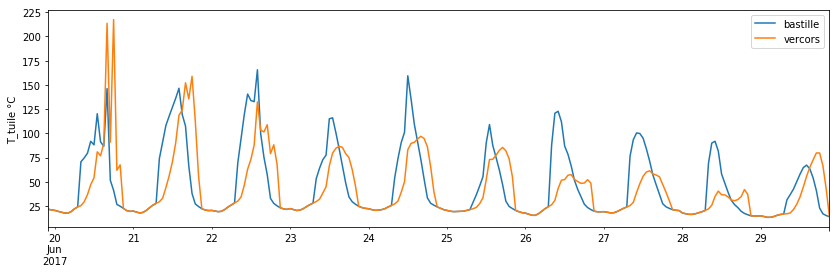

In [18]:
Ttuile.plot(figsize=(14, 4) ); plt.ylabel('T_tuile °C');

## Modèle avec le rayonement du toit

In [19]:
sigmaSB = 5.670373e-8 # Constante de Stefan-Boltzmann,   W.m-2.K-4

In [20]:
from scipy.optimize import brentq

In [21]:
def model02_apply( datarow, colflux=None, disp=False  ):
    flux_soleil = datarow[ colflux ]
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )
    
    emissivite_tuile = 0.92

    rayonement_soleil = (1-albedo_tuile)*flux_soleil
    convection = lambda T: -h * (T - T_air)
    rayonement_toit = lambda T: -sigmaSB*emissivite_tuile*( T + 273 )**4
    #rayonement_ciel =  +sigmaSB*( T_air + 273 )**4  # insert cloud cover here
    rayonement_ciel = Goforth_skyrad( datarow )
    
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    if disp:
        print( convection(T_eq), rayonement_toit(T_eq), rayonement_soleil, rayonement_ciel )
    
    return T_eq

In [22]:
def Goforth_skyrad( datarow ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    C = datarow['cloudCover']
    K = 0.2 #0.34 for very low clouds to 0.06 for very high clouds,
    T = datarow['temperature'] + 273
    RH = datarow['humidity']*100

    Pthermal = ( 1 + K*C**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal

In [23]:
Ttuile = {}
Ttuile['bastille'] = data.apply(model02_apply, axis=1, colflux='Flux_bastille')
Ttuile['vercors'] = data.apply(model02_apply, axis=1, colflux='Flux_vercors')

Ttuile = pd.DataFrame(Ttuile)

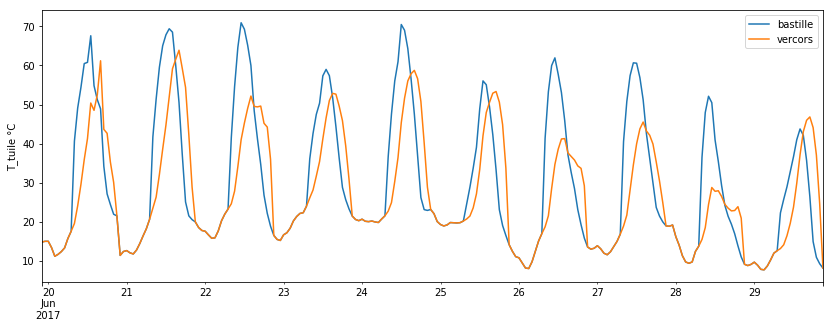

In [24]:
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

In [142]:
# Pour voir la repartition :
row = data.to_dict(orient='index')[pd.to_datetime( '27/06/2017 20h00' ) ]
model02_apply( row, colflux='Flux_bastille' , disp=True )

22.1614073331 -384.0090245135306 0.0 361.84761718


19.910873440447563

In [25]:
# Zoom
zoom_start = pd.to_datetime( '28/06/2017' ) 
mask = (data.index > zoom_start)

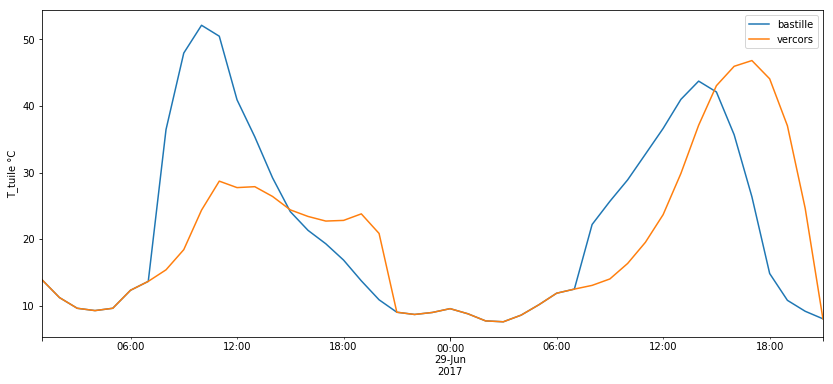

In [26]:
Ttuile.loc[mask].plot(figsize=(14, 6) ); plt.ylabel('T_tuile °C');

### Remarques
- 'true' temperature du ciel
- Radiation diffuse ? same as sky temp ?
- Prise en compte de la pluie ... ?
- Effet des velux ?
- Pour le mur vertical ? 

- La nuit Ttuile < T_air ... ? condensation ? convection inversée...

In [27]:
### Save model results

In [28]:
Ttuile.to_csv( './results/model02results.csv' )

## Modèle avec inertie thermique des tuiles

In [147]:
data_dict = data.to_dict(orient='list')
time_sec = data.index.astype(np.int64) // 10e9

def getdatarow( t ):
    datarow = {}
    for key, data in data_dict.items():
        datarow[key] = np.interp( t, time_sec, data )
    return datarow

In [148]:
getdatarow(  149859002 )

{'Flux_bastille': 0.0,
 'Flux_vercors': 193.03141390575928,
 'apparentTemperature': 24.121,
 'cloudCover': 0.6202222222222222,
 'humidity': 0.4700555555555555,
 'precipIntensity': 0.17733444444444446,
 'temperature': 24.121,
 'windBearing': 198.98333333333332,
 'windSpeed': 2.150611111111111}

In [149]:
def heat_flux(  T, t, col4sunflux=None  ):
    datarow = getdatarow( t )
    
    flux_soleil = datarow[ col4sunflux ]
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )
    
    rayonement_soleil = (1-albedo_tuile)*flux_soleil
    
    convection = -h * (T - T_air)
    rayonement_toit = -sigmaSB*emissivite_tuile*( T + 273 )**4

    rayonement_ciel = Goforth_skyrad( datarow )
    
    somme_flux = convection + rayonement_toit + rayonement_soleil + rayonement_ciel
    
    return somme_flux 

In [150]:
heat_flux( 40, 149859002,  col4sunflux='Flux_bastille' )

-261.3339323497062

In [151]:
# Masse thermique tuile

ep = 0.04 # m
rho = 2600 # kg/m3

masseSurfacique = 28 # kg /m 2
Cp = 960 # J/K/kg

k = 1 # W/m/K

In [152]:
ep*rho

104.0

In [153]:
D = k/rho/Cp
tau = ep**2/ D

print( 'temps carac. diff. ep tuille: %f min' % (tau/60) )

temps carac. diff. ep tuille: 66.560000 min


In [154]:
from scipy.integrate import odeint

In [155]:
side = 'Flux_bastille'
epRhoCp = masseSurfacique * Cp

def dTdt(T, t):
    return 1/epRhoCp * heat_flux(  T, t, col4sunflux=side  )


Tzero = 0
t_span = time_sec

res = odeint(dTdt, Tzero, t_span)
                       

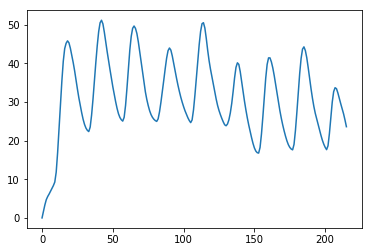

In [156]:
plt.plot(res )

In [157]:
Ttuile['inertie_bastille'] = res

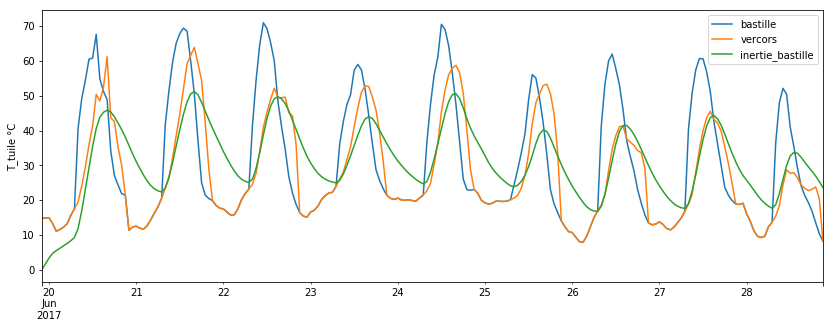

In [158]:
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

# Validation du modèle

mesure avec thermomètre infrarouge 

In [99]:
mesures = pd.read_csv('mesures/mesures_Ttuiles.csv', sep=';', index_col=2, parse_dates=True, decimal=',' )

In [100]:
mesures = mesures.drop(['Unnamed: 0', 'Unnamed: 1'], 1)

In [101]:
# Zoom
zoom_start = pd.to_datetime( '27/06/2017' ) 
mask = (data.index > zoom_start)

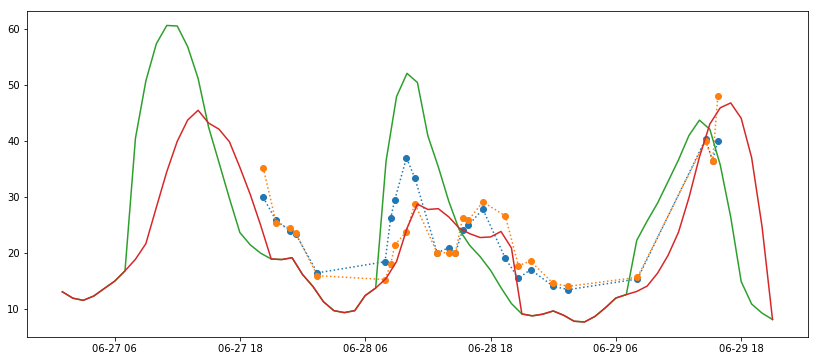

In [102]:
plt.figure( figsize=(14, 6) )
plt.plot( mesures, ':o' )
plt.plot( Ttuile.loc[mask], '-' );